## Prerequisites

In [1]:
%%capture
! pip install datasets evaluate transformers[torch]
! git clone https://github.com/PhilBurub/Enhancing-LLMs-with-Ontologies

In [4]:
import torch
import ssl
import json
import requests
import re
import zipfile
import torch
import datasets
import evaluate
import numpy as np
import pandas as pd
from torch import nn
from transformers import Trainer
from pathlib import Path
from collections import defaultdict
from datasets import Dataset, DatasetDict
from tqdm.notebook import tqdm
from itertools import repeat
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from huggingface_hub import notebook_login

In [5]:
tqdm.pandas()
pd.options.mode.chained_assignment = None

In [ ]:
notebook_login()

## Загрузка датасета Mintaka

In [ ]:
dataset_train = datasets.load_dataset('AmazonScience/mintaka', split='train')
dataset_test = datasets.load_dataset('AmazonScience/mintaka', split='test')
#dataset_valid = datasets.load_dataset('AmazonScience/mintaka', split='validation')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for AmazonScience/mintaka contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/AmazonScience/mintaka
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
def filter_types(dataset):
    df = dataset.to_pandas()
    df = df[(df.answerEntity.str.len() != 0) & (df.complexityType != 'count')]
    df.reset_index(drop=True, inplace=True)

    return df[['id', 'question', 'answerText']]

In [ ]:
filtered_ds_train = filter_types(dataset_train)
filtered_ds_test = filter_types(dataset_test)

In [ ]:
len(filtered_ds_train), len(filtered_ds_test)

(8576, 2436)

In [ ]:
filtered_ds_train.head()

,id,question,answerText
0,a9011ddf,What is the seventh tallest mountain in North ...,Mount Lucania
1,2723bb1b,Which actor was the star of Titanic and was bo...,Leonardo DiCaprio
2,88349c89,Which actor starred in Vanilla Sky and was mar...,Tom Cruise
3,982450cf,Who is the youngest current US governor?,Ron DeSantis
4,fe541d01,Which US president has had the most votes?,Joe Biden


## Подключение к GPT-3.5

In [ ]:
client = OpenAI(
    api_key='sk-s7mUtYgWNJMYCAlR8kUxcHB4JHknNbAO',
    base_url='https://api.proxyapi.ru/openai/v1',
)

In [ ]:
def generate(prompt):
    chat_completion = client.chat.completions.create(
      messages=[
          {
              'role': 'user',
              'content': prompt,
          }
      ],
      model='gpt-3.5-turbo',
      temperature=1,
      top_p=0.1,
      n=1,
      stream=False,
      max_tokens=512,
      frequency_penalty=1
    )
    return chat_completion.choices[0].message.content

In [ ]:
def remove_enumeration(text):
    pattern = r'^(?:\d+\.\s)?(.+)$'
    return re.match(pattern, text).group(1)

In [ ]:
def top_one_llm(question_text):
    prompt = 'You need to answer the question below only with the name of person, location, character etc. ' \
                'Do not give any additional information, facts and thoughts.\n' \
                'Question: ' + question_text + 'Your answer:'
    return generate(prompt)

def options_llm(question_text, n_vars):
    prompt = f'You need to answer the question below only with {n_vars} names of people, locations, characters etc. ' \
            'Do not give any additional information, facts and thoughts. ' \
            f'Generate {n_vars} most likely options, each one starting with newline, with enumeration.\n' \
            'Question: ' + question_text + '\nYour answers:'
    results = generate(prompt).strip('\n').split('\n')
    return list(map(remove_enumeration, results))

def get_inner_ontology(question_text, answer_text):
    prompt = 'You need to generate a hypernym for answer in question-answer pair below and output a string "<Hypernym of answer> is a subclass of <upper-level hypernym>". A hypernym can be a denomination of people, locations, characters, buildings, movies etc. '\
                'Do not give any additional information, facts and thoughts, answer as short as possible.\n' \
                'Question: Who is the oldest person to ever win an Academy Award in any category?\n' \
                'Answer: James Ivory\n' \
                'Output: Film director is a subclass of artists' \
                'Question: ' + question_text + '\nAnswer: ' + answer_text + '\nOutput:'

    results = generate(prompt).strip('\n')
    return results

In [ ]:
'''
def get_entities(question_text):
    prompt = 'You need to find all denominations of people, locations, characters, buildings, movies etc. '\
                'from the question below. ' \
                'Do not give any additional information, facts and thoughts. Each one should be on a separate line.\n' \
                'Question: Who starred in \'Bride Wars\' and married Anne Hathaway?\n' \
                'Answer: Bride Wars\nAnne Hathaway\n' \
                'Question: ' + question_text + '\nAnswer:'
    return generate(prompt).split('\n\n')

def relation_extraction(answer_candidate, entity):
    prompt = f'Explain how {entity} and {answer_candidate} are related in one sentence.'
    return generate(prompt)

def main_pipeline(question, n_candidates, database, n_ontology_instances):
    candidates = options_llm(question, n_candidates)
    ontological_info = {'inner': {}, 'outer': {}}
    entities = get_entities(question)
    for candidate in candidates:
        ontological_info['inner'][candidate] = '\n'.join([relation_extraction(candidate, entity) for entity in entities])
        ontological_info['outer'][candidate] = '\n'.join(database.query('Question: ' + question + '\nAnswer: ' + candidate,
                                                              n_ontology_instances)['documents'][0])
    return ontological_info, candidates[0]
'''

## Скачивание онтологии и инфопоиск по ней

In [ ]:
%%capture
!pip install wget
!pip install chromadb
!wget https://raw.githubusercontent.com/PhilBurub/NLPcourse_HSE/main/database.py

In [ ]:
db = VectDB()

In [ ]:
db.query('Question: Who is the tallest person in Hollywood?\nAnswer: Lana del Rey', top_n=3)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:02<00:00, 32.6MiB/s]


{'ids': [['527', '225', '543']],
 'distances': [[1.483119010925293, 1.4878209829330444, 1.4964747428894043]],
 'metadatas': [[None, None, None]],
 'embeddings': None,
 'documents': [['PlayboyPlaymate is a subclass of Person',
   'Cinema is a subclass of Venue',
   'Woman is a subclass of Person']],
 'uris': None,
 'data': None}

In [ ]:
db.query('Question: Who is the tallest person in Hollywood?\nAnswer: Ryan Gosling', top_n=3)

{'ids': [['546', '521', '556']],
 'distances': [[1.2251185178756714, 1.421507716178894, 1.484468936920166]],
 'metadatas': [[None, None, None]],
 'embeddings': None,
 'documents': [['Actor is a subclass of Artist',
   'MovieDirector is a subclass of Person',
   'AdultActor is a subclass of Actor']],
 'uris': None,
 'data': None}

In [ ]:
db.query('Question: Who is the tallest person in Hollywood?\nAnswer: Ryan Gosling', top_n=1)['documents'][0][0]

'Actor is a subclass of Artist'

**Пайплайн:**

1. Обращаемся к гигачату с вопросом, получаем топ-икс ответов
2. Для каждого ответа ищем информацию по онтологии
3. Подаём в модель sequence ranker триплеты *вопрос-ответ-онтология*
4. Берём топ-1 по рангу триплет в качестве ответа
5. (Замеряем качество)

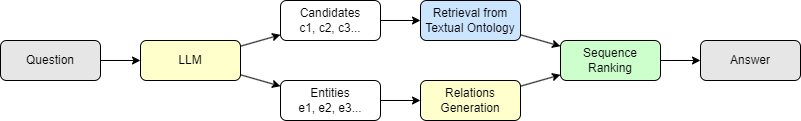

В промпт для нижнего пути (знания из самой ллм) не забыть написать типа Answer as short as possible.

### Data

In [ ]:
def generate_string_for_classify(question, answer_candidate, sep_token='[SEP]'):

    string_for_classify = ''
    question_and_answer = 'Question: ' + question + '\nAnswer: ' + answer_candidate
    ontology_information = db.query(question_and_answer, top_n=1)['documents'][0][0]
    string_for_classify += question + sep_token + answer_candidate + sep_token + ontology_information

    return string_for_classify

def are_similar(true_answer, answer_candidate):

    film_year_reg = re.compile('\(\d{4}\)')

    if answer_candidate[0] == '"' and answer_candidate[-1] == '"':
      answer_candidate = answer_candidate[1:-1]
    if len(re.findall(film_year_reg, answer_candidate)) ==  1 and len(re.findall(film_year_reg, true_answer)) == 0:
      answer_candidate = re.sub(film_year_reg, '', answer_candidate)

    if distance(true_answer, answer_candidate) <= 2:
      return 1
    else:
      return 0

Будем обучать не на всем датасете, а на его части:

In [ ]:
train_dataset_raw = filtered_ds_train[:1000]
test_dataset_raw = filtered_ds_test[:250]

In [ ]:
len(train_dataset_raw), len(test_dataset_raw)

(1000, 250)

In [ ]:
test_dataset_raw

,id,question,answerText
0,fae46b21,What man was a famous American author and also...,Mark Twain
1,d2a03f72,"Who is older, The Weeknd or Drake?",Drake
2,7ed1858c,"Which movie, starring Al Jolson, is generally ...",The Jazz Singer
3,bfc9807b,What state is the author of Misery from?,Maine
4,dbc6f3e8,"Which movie came out first, Monsters, Inc. or ...",Monsters Inc
...,...,...,...
245,b7d2f4ca,Which member of So Icey sold the most records ...,Gucci Mane
246,e262f71b,Which member of The Eagles did the back up voc...,Don Henley
247,39c74d8a,Which artist is part of Maroon 5 and was born ...,Jesse Royal Carmichael
248,45af1f8a,Which singer won the Grammy for Album of the Y...,Taylor Swift


добавить 5 колонок для кандидатов гигачата

## LLM: top 1

In [ ]:
test_dataset_raw['top1'] = test_dataset_raw['question'].progress_map(top_one_llm)
test_dataset_raw.to_csv('test_dataset_top1.csv', index=False)

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
train_dataset_raw['top1'] = train_dataset_raw['question'].progress_map(top_one_llm)
train_dataset_raw.to_csv('train_dataset_top1.csv', index=False)

## LLM: top 5

In [ ]:
def add_top5_to_dataframe(df):
    for i in range(1, 6):
        df['top' + str(i)] = ''
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        results = options_llm(row['question'], 5)
        for i in range(len(results)):
            row['top' + str(i + 1)] = results[i]
    return df

In [ ]:
test_dataset_raw = add_top5_to_dataframe(test_dataset_raw)
test_dataset_raw.to_csv('test_dataset_top5.csv', index=False)

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
train_dataset_raw = add_top5_to_dataframe(train_dataset_raw)
train_dataset_raw.to_csv('train_dataset_top5.csv', index=False)

## Read dataframes

In [ ]:
train_top5 = pd.read_csv('sequence_ranking/train_dataset_top5.csv')
test_top5 = pd.read_csv('sequence_ranking/test_dataset_top5.csv')

In [ ]:
def add_ontology_from_llm(df):

    ds = defaultdict(list)

    candidate_list = ['top1', 'top2', 'top3', 'top4', 'top5']

    for idx in tqdm(range(df.index.size)):
      candidates = [df.iloc[idx]['top1'], df.iloc[idx]['top2'], df.iloc[idx]['top3'], df.iloc[idx]['top4'], df.iloc[idx]['top5']]
      candidates = list(set(candidates))
      candidates = [x for x in candidates if type(x) == str]
      for candidate in candidates:
        label = are_similar(df.iloc[idx]['answerText'], candidate)
        ontology = get_inner_ontology(df.iloc[idx]['question'], candidate)
        string_for_classify = df.iloc[idx]['question'] + "[SEP]" + candidate + "[SEP]" + ontology

        ds['label'].append(label)
        ds['string_example'].append(string_for_classify)

    return ds

In [ ]:
train_dataset = add_ontology_from_llm(train_top5)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
train_dataset = Dataset.from_dict(train_dataset)
train_dataset.save_to_disk('train_dataset_llm')

Saving the dataset (0/1 shards):   0%|          | 0/4549 [00:00<?, ? examples/s]

In [ ]:
test_dataset = add_ontology_from_llm(test_top5)

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
test_dataset = Dataset.from_dict(test_dataset)
test_dataset.save_to_disk('test_dataset_llm')

Saving the dataset (0/1 shards):   0%|          | 0/1113 [00:00<?, ? examples/s]

## BERT classifier

In [6]:
train_dataset = datasets.load_from_disk('sequence_ranking/train_dataset_dbpedia')
test_dataset = datasets.load_from_disk('sequence_ranking/test_dataset_dbpedia')

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def model_init():
    model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
    for param in model.bert.parameters():
        param.requires_grad = False
    return model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
def tokenize_fn(examples):
    return tokenizer(examples['string_example'], padding='max_length', truncation=True)

train_dataset = train_dataset.map(tokenize_fn, batched=True).shuffle(seed=42)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

In [9]:
metric = evaluate.combine(['f1', 'precision', 'recall', 'accuracy'])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

In [10]:
target = np.array(train_dataset['label']).astype(int)

class_sample_count = np.unique(target, return_counts=True)[1]
weight = 1. / class_sample_count

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss (suppose one has 2 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weight).float()).to(logits.device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [11]:
def initialize_trainer(output_dir, model_init, num_train_epochs=2):
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        save_strategy='epoch',
        metric_for_best_model='precision',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,
        learning_rate=1e-5,
        weight_decay=0.01,
        logging_first_step=True,
        load_best_model_at_end=True,
        seed=42
    )
    trainer = CustomTrainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )
    return trainer

In [ ]:
trainer = initialize_trainer('sequence-ranker-llm-last-layer', model_init, 2)
trainer.train()

In [ ]:
trainer.push_to_hub()

In [ ]:
def model_second_stage_init():
    model = BertForSequenceClassification.from_pretrained('bert-base/sequence-ranker-llm-last-layer', num_labels=2)
    for param in model.bert.parameters():
        param.requires_grad = True
    return model

In [ ]:
trainer = initialize_trainer('sequence-ranker-for-llm-ontology', model_second_stage_init, 4)
trainer.train()

## Validation

In [12]:
def sequence_ranker_for_dbpedia_ontology_init():
    model = BertForSequenceClassification.from_pretrained('IvAnastasia/sequence-ranker-for-dbpedia-ontology', num_labels=2)
    return model

In [13]:
trainer = initialize_trainer(
    'sequence-ranker-for-dbpedia-ontology',
    sequence_ranker_for_dbpedia_ontology_init
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [89]:
def compute_accuracy(ds):

    prediction_output = trainer.predict(ds)

    logits_of_1 = prediction_output.predictions[:, 1]

    df = ds.to_pandas().drop(columns=['input_ids', 'token_type_ids', 'attention_mask'])
    df['question'] = df['string_example'].map(lambda x: x.split('[SEP]')[0])
    df['logits_of_1'] = logits_of_1

    question_set = set(df['question'])

    total_score = 0

    for question in question_set:
        sub_df = df[df['question'] == question]
        best_row = sub_df.loc[sub_df['logits_of_1'].idxmax()]
        total_score += best_row['label']

    print(total_score / len(set(df['question'])))

In [90]:
compute_accuracy(train_dataset)

0.566


In [91]:
compute_accuracy(test_dataset)

0.28
